# Import All Needed Libraries

In [ ]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, auc, classification_report

%load_ext autoreload
%autoreload 2

from src.ATR import atr_wilder
from src.RSI import rsi_wilder
from src.VWAP import vwap
from src.MACD import macd
from src.SR import support_resistance


In [3]:
# Load Csv
df = pd.read_csv("data/btcusd_15-min_data.csv", parse_dates= ['timestamp'])

# Set timestamp as index
df.set_index("timestamp", inplace=True)


# Add 200 Sma
df["sma200"] = ta.sma(df["close"], length=200)

# Add 50 Sma
df["sma50"] = ta.sma(df["close"], length=50)

# Add Rsi
df["rsi"] = rsi_wilder(df["close"]).shift(1)

# Add atr
df["atr"] = atr_wilder(df).shift(1)

# Add Vwap
df["vwap"] = vwap(df).shift(1)

# Add MACD
df["macd"] = macd(df).shift(1)

# Reversal signal
df['signal'] = ((df['rsi'] < 30) & (df['sma200'] > df['close'])).astype(int)

# Add Support and Resistance 
df = support_resistance(df, lookback=200)

# Add target
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)

# Drop empty rows
df.dropna(inplace=True)


print(df.tail())

                              open     high      low    close     volume  \
timestamp                                                                  
2026-02-15 22:45:00+00:00  68994.0  69037.0  68891.0  68917.0  23.809241   
2026-02-15 23:00:00+00:00  68954.0  68954.0  68292.0  68460.0  80.243542   
2026-02-15 23:15:00+00:00  68460.0  68628.0  68365.0  68615.0  21.635241   
2026-02-15 23:30:00+00:00  68617.0  68752.0  68517.0  68653.0  45.243957   
2026-02-15 23:45:00+00:00  68644.0  68792.0  68635.0  68792.0   7.486973   

                              sma200     sma50        rsi         atr  \
timestamp                                                               
2026-02-15 22:45:00+00:00  69473.045  69076.56  56.757986  225.212398   
2026-02-15 23:00:00+00:00  69470.680  69037.70  54.082214  219.554370   
2026-02-15 23:15:00+00:00  69469.420  69002.04  41.559412  251.157629   
2026-02-15 23:30:00+00:00  69468.255  68967.48  46.116651  252.003513   
2026-02-15 23:45:00+00:00  69

In [4]:
x = df.drop(columns='target')
y = df["target"]

# Split
split_idx = int(len(x) * 0.8)

x_train = x[:split_idx]
x_test = x[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=1.2,
    random_state=42
)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.55      0.53     49589
           1       0.51      0.48      0.49     49414

    accuracy                           0.51     99003
   macro avg       0.51      0.51      0.51     99003
weighted avg       0.51      0.51      0.51     99003



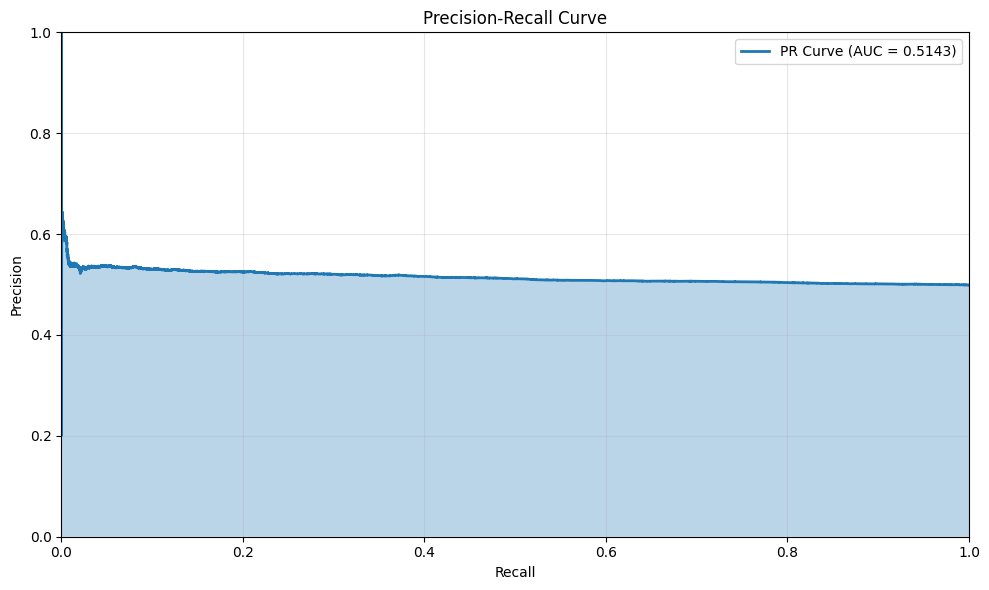

AUPRC (Area Under Precision-Recall Curve): 0.5143


In [5]:
# Get prediction probabilities
y_pred_proba = model.predict_proba(x_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate area under curve (AUPRC)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.fill_between(recall, precision, alpha=0.3)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

print(f"AUPRC (Area Under Precision-Recall Curve): {pr_auc:.4f}")

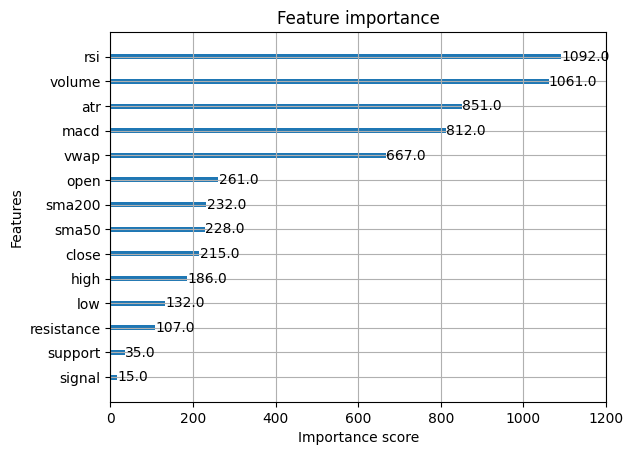

In [6]:
xgb.plot_importance(model)
plt.show()